# 悉尼天气预测

通过对悉尼当天的各种气象因素（湿度，压力，风向等）对第二天是否下雨，降水量多少进行预测。

数据集来源：https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

## 导入所需库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
pd.options.display.max_rows = None
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest,f_regression,f_classif,chi2
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 数据清理

读取数据集，检查数据类型以及缺失值数量。这里只读取悉尼天气数据，因此筛选掉其他城市的气象数据。

In [2]:
weather=pd.read_csv('weatheraus.csv')
weather_sydney=weather[weather['Location']=='Sydney']

In [3]:
weather_sydney.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
29497,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,6.0,Yes
29498,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,6.6,Yes
29499,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,18.8,Yes
29500,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,77.4,Yes
29501,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,1.6,Yes


In [4]:
weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 29497 to 32833
Data columns (total 24 columns):
Date             3337 non-null object
Location         3337 non-null object
MinTemp          3334 non-null float64
MaxTemp          3335 non-null float64
Rainfall         3331 non-null float64
Evaporation      3286 non-null float64
Sunshine         3321 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindDir9am       3281 non-null object
WindDir3pm       3304 non-null object
WindSpeed9am     3311 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity9am      3323 non-null float64
Humidity3pm      3324 non-null float64
Pressure9am      3317 non-null float64
Pressure3pm      3318 non-null float64
Cloud9am         2771 non-null float64
Cloud3pm         2776 non-null float64
Temp9am          3333 non-null float64
Temp3pm          3333 non-null float64
RainToday        3331 non-null object
RISK_MM          3337 non-null float

In [5]:
weather_sydney.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,3334.000000,3335.000000,3331.000000,3286.000000,3321.000000,2301.000000,3311.000000,3312.000000,3323.000000,3324.000000,3317.000000,3318.000000,2771.000000,2776.000000,3333.000000,3333.000000,3337.000000
mean,14.865057,23.002339,3.330231,5.187432,7.179374,41.761408,15.070674,19.335447,68.229010,54.699158,1018.346156,1016.018774,4.181523,4.218660,17.819742,21.533333,3.319868
std,4.553641,4.494638,9.895172,2.777407,3.810886,13.007523,7.079724,7.482554,15.085355,16.293530,7.021571,7.032211,2.749578,2.641885,4.897177,4.303737,9.885066
min,4.300000,11.700000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,19.000000,10.000000,986.700000,989.800000,0.000000,0.000000,6.400000,10.200000,0.000000
25%,11.000000,19.600000,0.000000,3.200000,4.300000,31.000000,9.000000,15.000000,58.000000,44.000000,1013.700000,1011.300000,1.000000,1.000000,13.800000,18.400000,0.000000
50%,14.900000,22.800000,0.000000,4.800000,8.300000,41.000000,15.000000,19.000000,69.000000,56.000000,1018.600000,1016.300000,5.000000,4.000000,18.200000,21.300000,0.000000
75%,18.700000,26.000000,1.400000,7.000000,10.200000,50.000000,20.000000,24.000000,80.000000,65.000000,1023.100000,1020.800000,7.000000,7.000000,21.700000,24.500000,1.400000
max,27.600000,45.800000,119.400000,18.400000,13.600000,96.000000,54.000000,57.000000,100.000000,99.000000,1039.000000,1036.700000,9.000000,8.000000,36.500000,44.700000,119.400000


从info()中可看出缺失值主要存在于每日最强风的风力与风速，以及云层厚度。接下来检查数据集中是否有重复数据，例如同一天的气象数据出现了多次。

In [6]:
weather_sydney=weather_sydney.drop_duplicates(subset='Date', keep='first', inplace=False)
weather_sydney.shape[0]

3337

数据集依旧是3337行，所以数据集中并没有重复日期。

预测变量‘RainToday’（今日是否下雨），‘Rainfall’（今日降水量）中各有6个缺失值，但是此变量值可由上一天的‘RainTomorrow’（明日是否下雨）及‘RISK_MM’（明日降水量）推测出，所以‘RainToday’与‘Rainfall’的缺失值可以用此法填补。

In [7]:
for index in weather_sydney.index:
    if pd.isnull(weather_sydney.loc[index,'RainToday']):
        weather_sydney.loc[index,['RainToday']]=weather_sydney.loc[index-1,['RainTomorrow']][0]
    if pd.isnull(weather_sydney.loc[index,'Rainfall']):
        weather_sydney.loc[index,['Rainfall']]=weather_sydney.loc[index-1,['RISK_MM']][0]

对于其余的缺失值我们选择将其所在行删除，最后剩余1692行数据。之后剔除不需要的列‘Date’，‘Location’，‘RainToday’，‘RainTomorrow’。

In [8]:
weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 29497 to 32833
Data columns (total 24 columns):
Date             3337 non-null object
Location         3337 non-null object
MinTemp          3334 non-null float64
MaxTemp          3335 non-null float64
Rainfall         3337 non-null float64
Evaporation      3286 non-null float64
Sunshine         3321 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindDir9am       3281 non-null object
WindDir3pm       3304 non-null object
WindSpeed9am     3311 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity9am      3323 non-null float64
Humidity3pm      3324 non-null float64
Pressure9am      3317 non-null float64
Pressure3pm      3318 non-null float64
Cloud9am         2771 non-null float64
Cloud3pm         2776 non-null float64
Temp9am          3333 non-null float64
Temp3pm          3333 non-null float64
RainToday        3337 non-null object
RISK_MM          3337 non-null float

In [9]:
weather_sydney=weather_sydney.dropna()
weather_sydney=weather_sydney.drop(columns=['Date','Location'])

对于类别变量，我们将‘Yes’和‘No’统一转化为1和0，并将风向变量向量化，即独热编码。

In [10]:
weather_sydney2=weather_sydney

In [11]:
weather_sydney=weather_sydney.replace('Yes',1)
weather_sydney=weather_sydney.replace('No',0)
weather_sydney= pd.get_dummies(weather_sydney,columns = ['WindGustDir','WindDir9am','WindDir3pm'],drop_first=True)

## 基础分析

首先分析风向因素，这里选取第二天会下雨的数据（RainTomorrow=Yes），统计下雨前一天的风向分布。

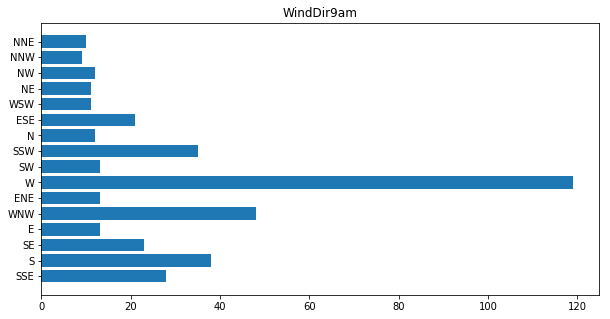

In [12]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindDir9am'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindDir9am')
plt.show()

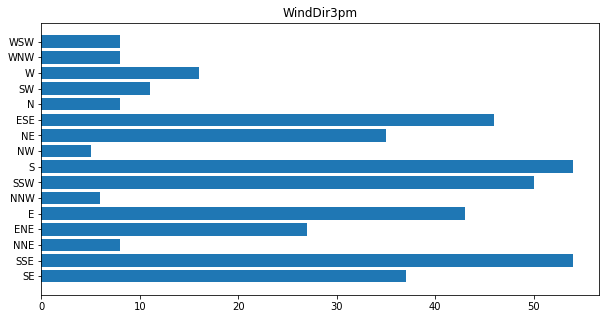

In [13]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindDir3pm'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindDir3pm')
plt.show()

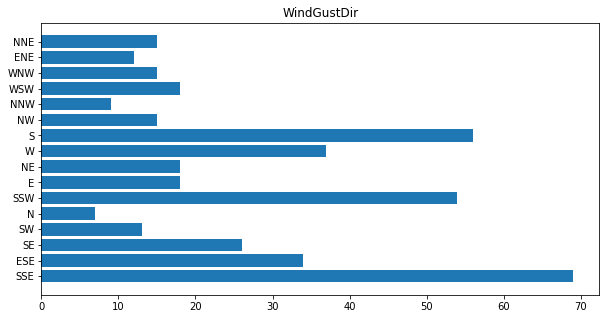

In [14]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindGustDir'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindGustDir')
plt.show()

可看出，如果上午9点风向为西风，下午3点风向大致为南风或东风，当日最大风为偏西南风时，第二天下雨情况居多。悉尼地处澳大利亚东南部，除了上午9点是情况，其他情况皆符合常理。

接下来分析云层厚度与降水的关系。

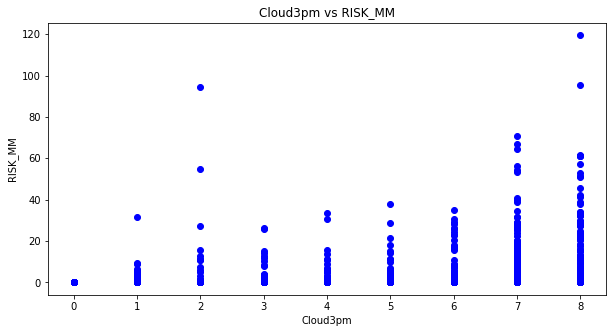

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Cloud3pm'],weather_sydney2['RISK_MM'],color='b')
plt.title('Cloud3pm vs RISK_MM')
plt.xlabel('Cloud3pm')
plt.ylabel('RISK_MM')
plt.show()

除了个别极端情况，总体上看随着云层厚度增加，第二天降水量有上升趋势。

湿度与降水也可观察到正相关关系。

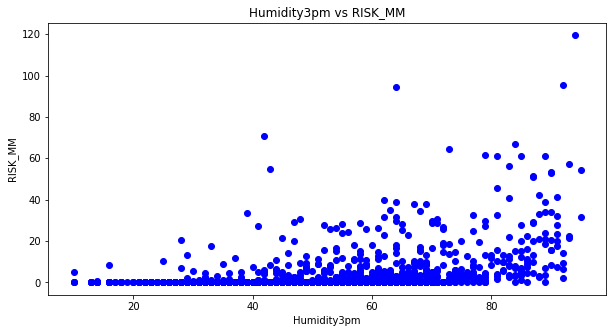

In [16]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Humidity3pm'],weather_sydney2['RISK_MM'],color='b')
plt.title('Humidity3pm vs RISK_MM')
plt.xlabel('Humidity3pm')
plt.ylabel('RISK_MM')
plt.show()

今天的降水量之间是否对明天的降水量有影响？由散点图看是呈负相关。

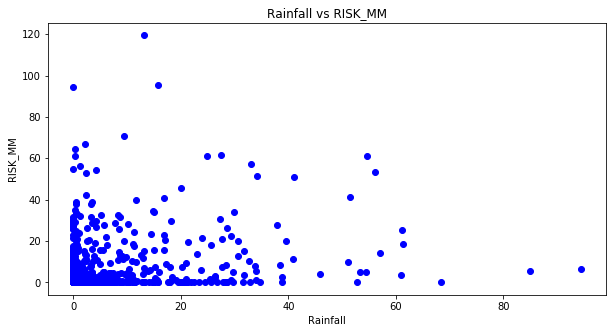

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Rainfall'],weather_sydney2['RISK_MM'],color='b')
plt.title('Rainfall vs RISK_MM')
plt.xlabel('Rainfall')
plt.ylabel('RISK_MM')
plt.show()

## 建模

### 线性回归

挑选其中对因变量影响最大的10个自变量

In [18]:
y=weather_sydney['RISK_MM']
X=weather_sydney.drop(columns=['RainToday','RainTomorrow','RISK_MM'])
best=SelectKBest(f_regression, k=10)
best.fit(X,y)


SelectKBest(k=10, score_func=<function f_regression at 0x0000027DF63CC598>)

In [19]:
columns=X.columns[best.get_support(indices=True)]
print(columns)

Index(['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am',
       'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'WindDir9am_S'],
      dtype='object')


In [20]:
X=best.transform(X)

In [21]:
lin = LinearRegression()
lin.fit(X,y)
pd.DataFrame(data={'feature':columns,'coef':lin.coef_})

,feature,coef
0,MaxTemp,-0.270351
1,Rainfall,0.159397
2,Sunshine,-0.450469
3,WindGustSpeed,0.150976
4,Humidity9am,-0.000762
5,Humidity3pm,0.159711
6,Cloud9am,-0.155410
7,Cloud3pm,0.043300
8,Temp3pm,0.176390
9,WindDir9am_S,1.955829


In [22]:
y_pred = lin.predict(X)
r2_score(y, y_pred)

0.25579353440315444

在此我们得到模型的$R^2$约为0.26，鉴于气象有很强的不确定性，在此可认为模型拟合情况较为良好。
首先观察模型系数，‘WindDir9am_S’的系数最高，说明上午9点刮西南风可能会增加第二天的降水量。还可发现在适度与云层厚度中，上午9时的适度与云层厚度对第二天的降水量有负作用。然而我们注意到，在这个模型里，今天的降水量会提升第二天的降水量。

尝试仅预测是否下雨，即分类。这里我们使用逻辑回归。使用前先剔除掉数据集中记录明日降水量的‘RISK_MM’，并将‘RainTomorrow’作为预测对象。

In [23]:
y=weather_sydney['RainTomorrow']
X=weather_sydney.drop(columns=['RainToday','RainTomorrow','RISK_MM'])
best=SelectKBest(f_classif, k=10)
best.fit(X,y)


SelectKBest(k=10, score_func=<function f_classif at 0x0000027DF63CC400>)

In [24]:
columns=(X.columns[best.get_support(indices=True)])

In [25]:

X=best.transform(X)
y=weather_sydney['RainTomorrow']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

clf_logreg = LogisticRegression(random_state=0)
clf_logreg.fit(X_train,y_train)
y_pred = clf_logreg.predict(X_test)
score = accuracy_score(y_test,y_pred)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


在测试集上这个模型得到了约83%的准确率

In [26]:
score

0.8416075650118203